Analysis of 3 Million Instacart Orders data.

Data source: I came across this data from kaggle competition. https://www.kaggle.com/c/instacart-market-basket-analysis/data

Data is open sourced and available from this link -> https://www.instacart.com/datasets/grocery-shopping-2017

Data dictionary -> https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b

Overview of all tables and columns -> https://www.kaggle.com/c/instacart-market-basket-analysis/discussion/33128#183176

In [4]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import os, psutil; process = psutil.Process(os.getpid())
os.chdir('E:\\kaggle\\market_basket')

In [5]:
print('Memory usage ~ {:.2f} GB'.format(process.memory_info().rss / (float(1024**3))))

Memory usage ~ 0.10 GB


Taken help of this kernel
https://www.kaggle.com/yohanb/data-manipulation-low-memory-under-8-gb

In [8]:
op_prior = pd.read_csv('order_products__prior.csv', engine='c',
                                   dtype={'order_id':np.int32, 
                                          'product_id':np.int32, 
                                          'add_to_cart_order':np.int8, 
                                          'reordered':np.int8})

op_train = pd.read_csv('order_products__train.csv', engine='c',
                                   dtype={'order_id':np.int32, 
                                          'product_id':np.int32, 
                                          'add_to_cart_order':np.int8, 
                                          'reordered':np.int8})
orders = pd.read_csv('orders.csv', engine='c',
                     dtype={'order_id':np.int32,
                            'user_id':np.int32,
                            'order_number':np.int8,
                            'order_dow':np.int8,
                            'order_hour_of_day':np.int8
                           })
products = pd.read_csv('products.csv', engine='c',
                       dtype={'product_id':np.int32,
                              'aisle_id':np.int8,
                              'department_id':np.int8
                             })
aisles = pd.read_csv('aisles.csv', engine='c', dtype={'aisle_id':np.int16})
departments = pd.read_csv('departments.csv', engine='c', dtype={'department_id':np.int16})

In [9]:
# check number of rows and columsn
print('aisles',aisles.shape)
print('departments',departments.shape)
print('op_prior',op_prior.shape)
print('op_train',op_train.shape)
print('orders',orders.shape)
print('products',products.shape)

aisles (134, 2)
departments (21, 2)
op_prior (32434489, 4)
op_train (1384617, 4)
orders (3421083, 7)
products (49688, 4)


In [10]:
# check for missing values anywhere in the table
print('aisles',aisles.isnull().values.any())
print('departments',departments.isnull().values.any())
print('op_prior',op_prior.isnull().values.any())
print('op_train',op_train.isnull().values.any())
print('orders',orders.isnull().values.any())
print('products',products.isnull().values.any())

aisles False
departments False
op_prior False
op_train False
orders True
products False


In [11]:
# Missig Values exists in Orders Table
print(orders.isnull().sum())

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64


Only days_since_prior_order is having missing values.

In [12]:
# impute missing values to -1
orders.days_since_prior_order.fillna(-1,inplace=True)
orders.days_since_prior_order = orders.days_since_prior_order.astype(np.int8)

In [13]:
# combine aisles, departments and products (left joined to products)
goods = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
# changing space in product names to '_'
goods.product_name = goods.product_name.str.replace(' ', '_').str.lower() 

In [14]:
goods.shape

(49688, 6)

In [15]:
# Merge Orders and Order_products_train data
train_orders = pd.merge(left=op_train,
                        right = orders,
                        how = 'left',
                        on = 'order_id')

In [16]:
# Merge goods data to train dataset
train_order_details = pd.merge(left = train_orders,
                 right = goods,
                 how = 'left',
                 on = 'product_id')

In [17]:
# Merge Orders and Order_products_prior data
prior_orders = pd.merge(left=op_prior,
                        right=orders,
                        how = 'left',
                        on='order_id')


In [18]:
# Filter the prior orders of the users from the train data set. 
prior_train_orders = prior_orders[prior_orders.user_id.isin(train_orders.user_id.unique())]
#print(prior_orders.user_id.nunique())
#print(train_orders.user_id.nunique())
#print(prior_train_orders.user_id.nunique())

In [19]:
# Merge goods data to train dataset
prior_train_order_details = pd.merge(left = prior_train_orders,
                 right = goods,
                 how = 'left',
                 on = 'product_id')

In [20]:
prior_train_order_details[prior_train_order_details.user_id==1].sort_values(['order_number'])

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
15325989,2539329,26405,5,0,1,prior,1,2,8,-1,xl_pick-a-size_paper_towel_rolls,54,17,household,paper goods
15325988,2539329,26088,4,0,1,prior,1,2,8,-1,aged_white_cheddar_popcorn,23,19,snacks,popcorn jerky
15325987,2539329,12427,3,0,1,prior,1,2,8,-1,original_beef_jerky,23,19,snacks,popcorn jerky
15325986,2539329,14084,2,0,1,prior,1,2,8,-1,organic_unsweetened_vanilla_almond_milk,91,16,dairy eggs,soy lactosefree
15325985,2539329,196,1,0,1,prior,1,2,8,-1,soda,77,7,beverages,soft drinks
14475646,2398795,196,1,1,1,prior,2,3,7,15,soda,77,7,beverages,soft drinks
14475651,2398795,13032,6,0,1,prior,2,3,7,15,cinnamon_toast_crunch,121,14,breakfast,cereal
14475650,2398795,26088,5,1,1,prior,2,3,7,15,aged_white_cheddar_popcorn,23,19,snacks,popcorn jerky
14475647,2398795,10258,2,0,1,prior,2,3,7,15,pistachios,117,19,snacks,nuts seeds dried fruit
14475648,2398795,12427,3,1,1,prior,2,3,7,15,original_beef_jerky,23,19,snacks,popcorn jerky


In [21]:
train_order_details[train_order_details.user_id==1].sort_values(['order_number'])

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
484420,1187899,196,1,1,1,train,11,4,8,14,soda,77,7,beverages,soft drinks
484421,1187899,25133,2,1,1,train,11,4,8,14,organic_string_cheese,21,16,dairy eggs,packaged cheese
484422,1187899,38928,3,1,1,train,11,4,8,14,0%_greek_strained_yogurt,120,16,dairy eggs,yogurt
484423,1187899,26405,4,1,1,train,11,4,8,14,xl_pick-a-size_paper_towel_rolls,54,17,household,paper goods
484424,1187899,39657,5,1,1,train,11,4,8,14,milk_chocolate_almonds,45,19,snacks,candy chocolate
484425,1187899,10258,6,1,1,train,11,4,8,14,pistachios,117,19,snacks,nuts seeds dried fruit
484426,1187899,13032,7,1,1,train,11,4,8,14,cinnamon_toast_crunch,121,14,breakfast,cereal
484427,1187899,26088,8,1,1,train,11,4,8,14,aged_white_cheddar_popcorn,23,19,snacks,popcorn jerky
484428,1187899,27845,9,0,1,train,11,4,8,14,organic_whole_milk,84,16,dairy eggs,milk
484429,1187899,49235,10,1,1,train,11,4,8,14,organic_half_&_half,53,16,dairy eggs,cream


We See that, for user_id = 1, 10 of the prior orders are present in prior_order dataset and the 11th order in train data. Let's combine these two to get our train dataset.

Also,

Reordered colomn will tell us if the product is begin ordered for the first time or not.

order number will give us the sequence of order

add_to_cart_order gives us the sequence by which the product is added to cart

In [74]:
# append prior_in_train and train_orders
#train_prior_orders = pd.concat([prior_in_train,train_orders])

In [22]:
# perpare test data
test_orders = orders[orders.eval_set=='test']

In [23]:
prior_test_orders = prior_orders[prior_orders.user_id.isin(test_orders.user_id.unique())]

In [24]:
prior_test_order_details = pd.merge(left = prior_test_orders,
                 right = goods,
                 how = 'left',
                 on = 'product_id')

In [94]:
#test_prior_orders = pd.concat([prior_in_test,test_orders])

Data Exploration

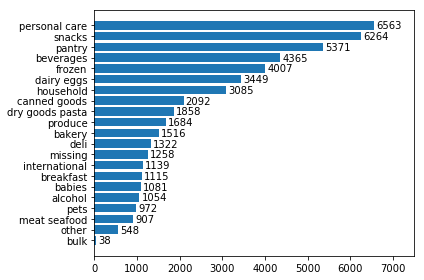

In [25]:
# distribution of number of Products in each department
ind = np.arange(goods['department'].nunique())
y = goods.groupby(['department']).count()['product_id'].sort_values()
fig, ax = plt.subplots()
ax.barh(ind, y)
ax.set_yticks(ind)
ax.set_yticklabels(y.index)
for i,v in enumerate(y):
    ax.text(v+50, i-0.3,str(v))
ax.set_xlim([0,7500])    
fig.tight_layout()
plt.show()

Missing category seems bit strange here. 

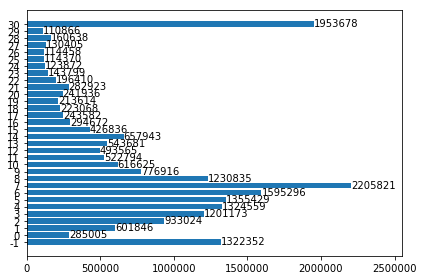

In [35]:
# after how many days the people purchase again
ind = np.arange(prior_train_order_details['days_since_prior_order'].nunique())
y = prior_train_order_details['days_since_prior_order'].value_counts(dropna=False).sort_index()
fig, ax = plt.subplots()
ax.barh(ind, y)
ax.set_yticks(ind)
ax.set_yticklabels(y.index)
for i,v in enumerate(y):
    ax.text(v+50, i-0.35,str(v))
ax.set_xlim([0,2550000]) 
fig.tight_layout()
plt.show()

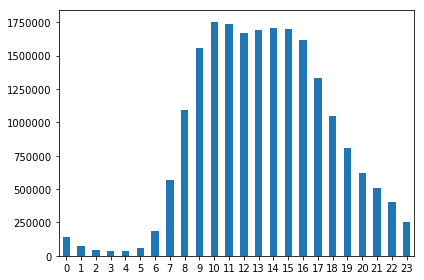

In [36]:
# waht time of day people tend to buy
fig = plt.figure()
prior_train_order_details['order_hour_of_day'].value_counts(dropna=False).sort_index().plot(kind='bar')
plt.xticks(rotation='horizontal')
fig.tight_layout()
plt.show()

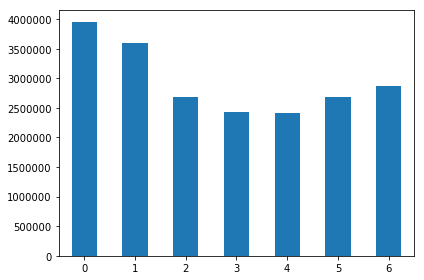

In [37]:
# day in a week 
fig = plt.figure()
prior_train_order_details['order_dow'].value_counts(dropna=False).sort_index().plot(kind='bar')
plt.xticks(rotation='horizontal')
fig.tight_layout()
plt.show()

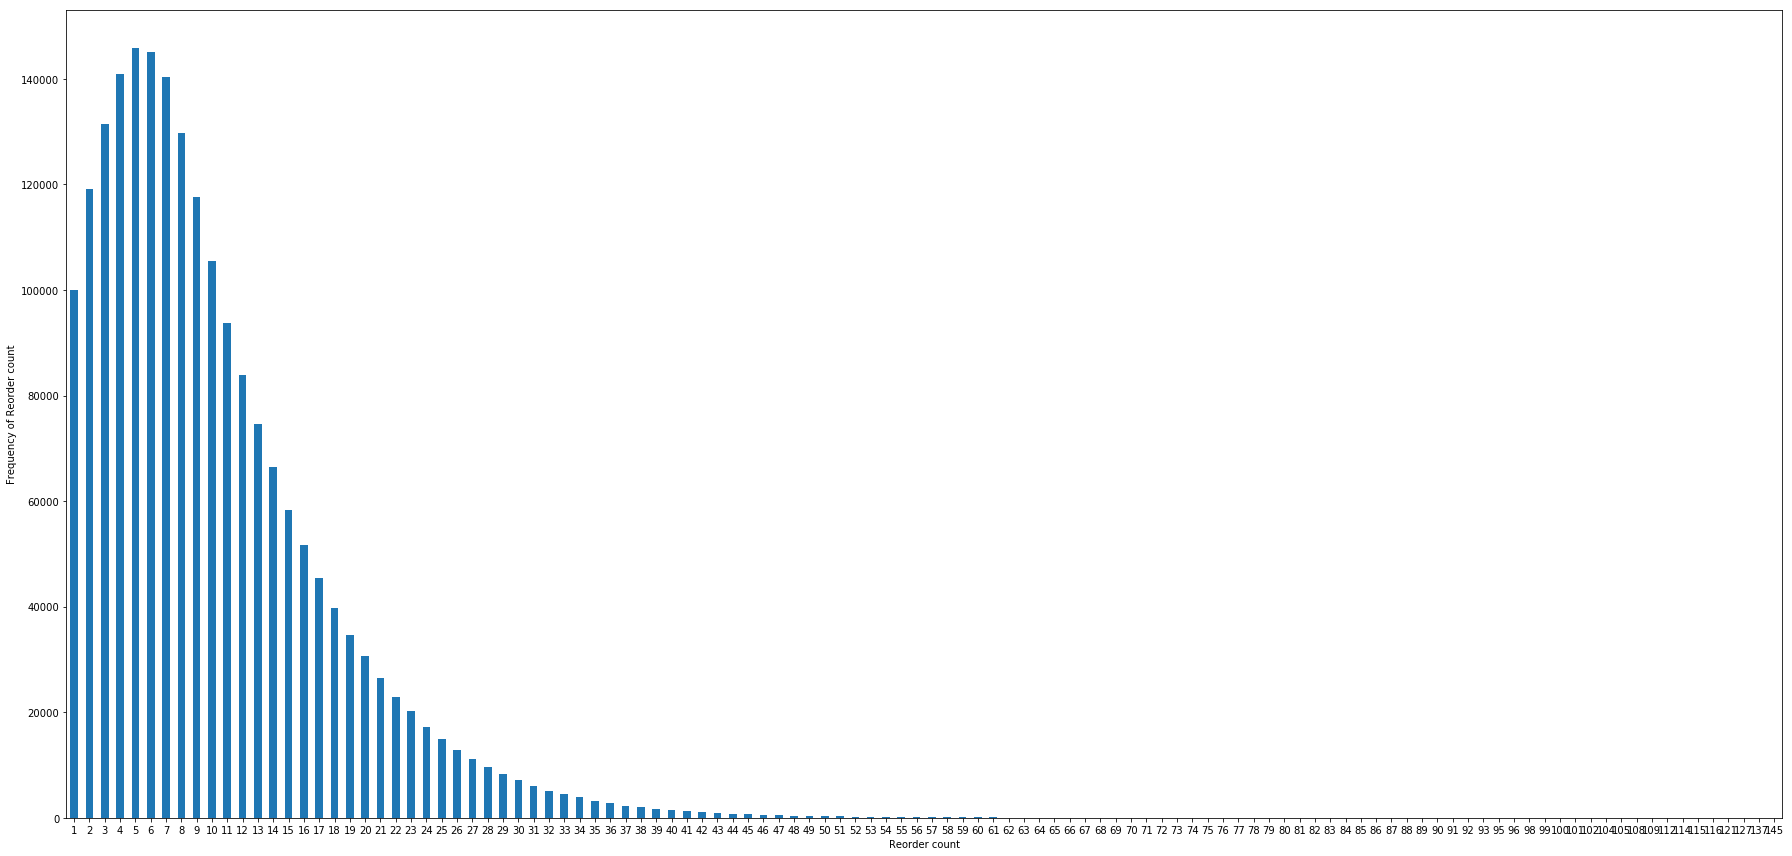

'The way this graph works is. on the x axis we have reorder count,\nHow many times single product is ordered again and again by single customer.\nThere are several products which are ordered 5 to 10 times by sinngle customer'

In [45]:
# how many times people buy
fig = plt.figure(figsize=(25,12))
prior_train_order_details.groupby(['order_id']).count()['product_id'].\
groupby(prior_train_order_details.groupby(['order_id']).count()['product_id']).count().plot(kind='bar')
plt.xticks(rotation='horizontal')
plt.xlabel('Reorder count')
plt.ylabel('Frequency of Reorder count')
fig.tight_layout()
plt.show()

"""The way this graph works is. on the x axis we have reorder count,
How many times single product is ordered again and again by single customer.
There are several products which are ordered 5 to 10 times by sinngle customer"""


In [46]:
#prior_test_order_details.to_csv('prior_test_order_details.csv',encoding='utf-8',index=False)

In [47]:
#prior_train_order_details.to_csv('prior_train_order_details.csv',encoding='utf-8',index=False)

In [48]:
#test_orders.to_csv('test_orders.csv',encoding='utf-8',index=False)

In [49]:
#train_order_details.to_csv('train_order_details.csv',encoding='utf-8',index=False)

In [50]:
#train = pd.concat([prior_train_order_details,train_order_details])

In [51]:
#train.to_csv('train.csv',encoding='utf-8',index=False)

In [ ]:
prior_train_order_details = pd.read_csv('prior_train_order_details.csv')

In [ ]:
train_orders = pd.read_csv('train_orders.csv')

In [4]:
prior_test_order_details = pd.read_csv('prior_test_order_details.csv')

In [61]:
test_orders = pd.read_csv('test_orders.csv')

In [63]:
test_orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2774568,3,test,13,5,15,11
1,329954,4,test,6,3,12,30
2,1528013,6,test,4,3,16,22
3,1376945,11,test,8,6,11,8
4,1356845,12,test,6,1,20,30


In [52]:
# User_id those who never reordered in test data
test_one_time_users=prior_test_order_details.groupby('user_id')['reordered'].sum().\
                     loc[lambda x: x==0].reset_index()['user_id']

In [53]:
test_one_time_users.shape
#prior_test_order_details[prior_test_order_details.user_id.isin(test_one_time_users.user_id)]['user_id'].nunique()

(1103,)

There are 1103 distinct user_id out of 75000 with no reordered history.

In [33]:
#Let's make a flag variable to distinguesh them in our test dataset
#prior_test_order_details['onetime_users']=prior_test_order_details.apply(lambda x: 1
#                                                                          if (x['user_id'] in (test_one_time_users['user_id']))
#                                                                          else 0, axis =1)

In [57]:
# extract most frequencly ordered products fro each user id (excluding the users with no reorder records)
test_freq_products=prior_test_order_details[~prior_test_order_details.user_id.isin(test_one_time_users)]\
               .groupby(['user_id','product_id','product_name']).count()['order_number'].reset_index()

In [58]:
test_freq_products = test_freq_products[test_freq_products['order_number']==test_freq_products.groupby(['user_id'])['order_number'].transform(max)]
test_freq_products.rename(columns={'order_number':'Max_order_count'},inplace=True)

In [64]:
test_freq_products.sort_values('Max_order_count',ascending=False).head()

,user_id,product_id,product_name,Max_order_count
414592,17997,4210,whole_milk,99
3316370,141736,25133,organic_string_cheese,99
2831545,120897,12013,pinot_noir,98
1980303,84478,31981,1%_low_fat_milk,97
2296439,98085,196,soda,97


In [67]:
# Frequently ordered products across all users 
#test_freq_products.sort_values(['Max_order_count'],ascending=False).head(10)
test_freq_products.groupby(['product_id','product_name']).sum()['Max_order_count']\
.sort_values(ascending=False).reset_index().head(10)

,product_id,product_name,Max_order_count
0,24852,banana,71419
1,13176,bag_of_organic_bananas,43674
2,27845,organic_whole_milk,16760
3,47766,organic_avocado,12342
4,21903,organic_baby_spinach,11603
5,47209,organic_hass_avocado,10138
6,21137,organic_strawberries,8933
7,19660,spring_water,8748
8,44632,sparkling_water_grapefruit,6242
9,16797,strawberries,5844
